# Entraînement sans data-augmentation

In [113]:
from bs4 import BeautifulSoup
import requests
import re
import unidecode
import time
import os
import json
import joblib
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import nlpaug

from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer

# ---- first times : 
# nltk.download('wordnet')from sklearn.model_selection import GridSearchCV
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('stopwords')
# nltk.download('omw-1.4')

### Déclaration des fonctions

In [114]:
def replace_par_regex(tex:str, langue='francais') ->str :
    
    """
    mets les# liste2 = pd.DataFrame(liste)

# liste2.to_csv('dataaug.csv', index=False)it caractères en minuscule
    supprime les caractères non alphabétiques
    """

    # mettre le texte en minuscule
    pe = tex.lower()


    if langue == 'english':
        pe = re.sub('[^a-z_]','_',pe)
    else:
        pe = re.sub('[^a-zàâçéèêëîïôûùüÿñæœ]', '_', pe)
    
    # supprimer les mots de 1 ou deux lettres
    pe = re.sub('_[a-zàâçéèêëîïôûùüÿñæœ]{1,2}_', '_',pe)

    pe = re.sub('[_]{2,}','_',pe)
    pe = re.sub('_',' ',pe)
    
    # supprimer le l qui reste parfois
    pe = re.sub(' l ',' ', pe)

    return pe



def nbr_pages(u_r_l) -> int :  
    """
    trouve le nombre de pages à parser en fonction de l'indicatif des pages dans la première page html
    renvoie -1 en cas d'erreur    
    """

    soupObject = parse(u_r_l)
    
    # récupérer dans une liste les éléments de la calsse pagination-item-holer
    res = soupObject.find_all("div", class_="pagination-item-holder")

    # créer une chaîne de caractère à partir de la liste
    st = ""
    for el in res:
        st = st + (str(el))

    st = st.replace('>', '<')

    tab = st.split('<')

    ls = []
    for i in tab:

        try:
            ls.append(int(i))
        except:
            continue

    if len(ls) > 0:
        return max(ls)
    else:
       return 1



def afficher_nuage_mots(var:str, nombre_de_mots:int, langage='francais', *args):

    """
    affiche un nuage de mots les plus importants dans un texte
    prend en variables une chaîne de caractère, le nombre de mots importants à afficher, la langue, un tuple d'éventuels mots à ajouter au stopwords
    """


    if langage == 'english':
        SW = stopwords.words('english')
    else:
        SW = stopwords.words('french')
    

    if args:
        for el in args:
            SW.append(el)

    
    WC = WordCloud(background_color = 'white', stopwords = SW, max_words = nombre_de_mots).generate(var)
    plt.imshow(WC)
    plt.axis("off")
    plt.show()



def parse(u_r_l, html = True):

    """
    récupère le contenu d'une page html
    structure la réponse de requests
    transforme en objet avec ou sans le html
    retourne un objet Beautiful ou une chaîne de caractère    
    """

    # récupérer le contenu d'une page web
    page = requests.get(u_r_l)

    # structure la page
    soup = BeautifulSoup(page.content, 'html.parser')


    if html == False:
        soup = str(soup.get_text())
        
    
    return soup



def find_comment_and_rating(u_r_l):
    
    """
    trouver la division de la note, et retourner la note en float
    trouver la div du commentaire et retourner le commentaire
    """

    global dico

    # div de la note
    division_principale = 'hred review-card cf'
    division_note = "stareval-note"
    division_commentaire = "content-txt review-card-content"

    # récupérer la page internet
    soup = parse(u_r_l)
    foo = soup.find_all("div", class_= division_principale)

    title = soup.find('div', class_='titlebar titlebar-page')
    title = title.get_text()

    # récupérer la div des notes 

    dico = dict()
    

    for i in range(len(foo)):

        # parsage du parsage

        # --- la note
        ts = str(foo[i])
        fff = BeautifulSoup(ts, 'html.parser')
        ggg = fff.find('span', class_= division_note)

        # récupérer la note sans le html
        ggg  = ggg.get_text()
        ggg  = float(ggg.replace(',','.'))


        # --- le commentaire
        hhh = fff.find('div', class_= division_commentaire)
        hhh = hhh.get_text()
        hhh = replace_par_regex(hhh)

        dico[hhh] = ggg
       
    return dico, title



def recuperer_donnees_to_df(u_r_l):
    
    dci, title = find_comment_and_rating(u_r_l)
    nombre_de_pages_a_parser = nbr_pages(u_r_l)

    suffixe_url = '?page='

    url_complete = u_r_l + suffixe_url

    for i in range(2, nombre_de_pages_a_parser + 1):
        url = url_complete + str(i)
        
        try:
            data, _ = find_comment_and_rating(url)
            dci.update(data)
        except:
            continue

        time.sleep(0.2)


    # enregistrer le dictionnaire en csv ; le nom du csv est le timestamp

    ts = time.time()
    ts = str(int(ts))
    ts = ts + '.csv'
    title = title + '.csv'

    df = pd.DataFrame.from_dict(dci, orient='index')
    try:
        df.to_csv('./datas/'+title)
    except:
        df.to_csv('./datas/'+ts)


def clean_csv():

    """
    supprimer les fichiers csv du répertoire
    """

    for el in os.listdir():
        if 'csv' in el:
            os.remove(el)
  


def recupere_csv():
    
    """
    récupérer les fichiers csv créés
    """
    
    liste = []
    for fichier in (os.listdir('./data')):
        if 'csv' in fichier:

            adresse = os.path.join('data', fichier)
            
            liste.append(pd.read_csv(adresse))

    return liste, len(liste)


def lemm_stem(dataset, type='stem'):
    
    """
    lemmization ou stemming d'un dataset
    pour la lemmization, nécessité d'enlever les accents 
    retourne le dataset traité
    """



    french_stopwords = nltk.corpus.stopwords.words('french')
    lemmatizer = FrenchLefffLemmatizer()
    wnl = WordNetLemmatizer() 
    stemmer = SnowballStemmer(language='french')



    if type =='lemm':

        for i in range(dataset.shape[0]):

            st = ""    
            var = unidecode.unidecode(dataset.iloc[i])
            tokenize_sentence = nltk.tokenize.word_tokenize(var)   
            words_w_stopwords = [i for i in tokenize_sentence if i not in french_stopwords]    
            words_lemmatize = [wnl.lemmatize(w) for w in words_w_stopwords] 
            for j in range(len(words_lemmatize)):
                st = st + ' ' + words_lemmatize[j] + ' '
            dataset.iloc[i] = st
        
        return dataset


    if type =='stem':

        for i in range(dataset.shape[0]):

            st = ""
            tokenize_sentence = nltk.tokenize.word_tokenize(dataset.iloc[i])
            words_w_stopwords = [i for i in tokenize_sentence if i not in french_stopwords]
            words_stemming = [stemmer.stem(w) for w in words_w_stopwords]
            for j in range(len(words_stemming)):
                st = st + ' ' + words_stemming[j] + ' '
            dataset.iloc[i] = st

        return dataset


def sac_de_mots(dataframe, sac):
    
    """
    ne garder que les mots du sacs de mots
    """

    for i in range(dataframe.shape[0]):


        liste = np.array(dataframe.iloc[i].split(' '))
        bag = np.array(sac)

        res = np.intersect1d(bag, liste) 
    
        stri = ""

        for occ in list(res):

            stri = stri + ' ' + occ

        dataframe.iloc[i] = stri



def intersection(datafram, sac):

    
    dataframe = datafram.copy()
    # for i in range(dataframe.shape[0]):
    for i in range(10):

        phra = np.array(dataframe.iloc[i].split())

        phra = np.intersect1d(phra, sac)
    
        st = ""
        for j in range(phra.shape[0]):
            st = st + " " + phra[j]

        dataframe.iloc[i] = st 

    return dataframe

In [33]:
# URLS
# url_inception = 'https://www.allocine.fr/film/fichefilm-143692/critiques/spectateurs/'
# url_sonic2 = "https://www.allocine.fr/film/fichefilm-281203/critiques/spectateurs/"

# liste_url = [url_inception, url_sonic2]

## récupérer le nombre de pages et les commentaires avec la fonction find_comment_and_rating

### recupere_donnees_to_df scrape les pages et enregistre les infos en csv

In [34]:
# for rl in liste_url: 

#     recuperer_donnees_to_df(rl)

In [35]:
# pour télécharger 1000 films supplémentaires

# for i in range(1000):

#     j = 20000 + i
#     j = str(j)
#     urll = 'https://www.allocine.fr/film/fichefilm-'+j+'/critiques/spectateurs/'

#     try:
#         recuperer_donnees_to_df(urll)
#     except:
#         continue

## Récupérer tous les csv

In [115]:
liste, lenListe = recupere_csv()## récupérer le nombre de pages et les commentaires avec la fonction find_comment_and_rating

df = liste[0]

for i in range (1, lenListe):

    df = pd.concat((df, liste[i]), ignore_index=True)

In [118]:
# enregistrement du csv pour utilisation dans le fichier train_aug.ipynb
# df.to_csv('data_total.csv', index=False)

Renommer les colonnes

In [37]:
df = df.rename(columns={'Unnamed: 0':'commentaire', '0':'note'})

In [38]:
df.head()

,commentaire,note
0,film très lent plutôt hermétique est une oeuv...,2.0
1,faut voir genre film pour croire ils existent...,3.0
2,des acteurs français jouant les américains ba...,0.5
3,livre boris vian tourné film dans les années ...,5.0
4,irai cracher est sans doute œuvre française p...,1.0


In [39]:
print(f'{df.shape[0]:-<20} nombre de lignes')
print(f'{df.shape[1]:-<20} nombre de colonnes')

49025--------------- nombre de lignes
2------------------- nombre de colonnes


voir la répartition des notes

<AxesSubplot:ylabel='note'>

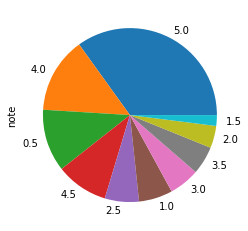

In [40]:
df['note'].value_counts().plot.pie()

changer les valeurs pour effectuer une classification binaire

In [41]:
for i in range(df.shape[0]):

    if df.loc[i, 'note'] > 2.5:
        df.loc[i, 'note'] = 1
    else:
        df.loc[i, 'note'] = 0


voir la répartition

<AxesSubplot:ylabel='note'>

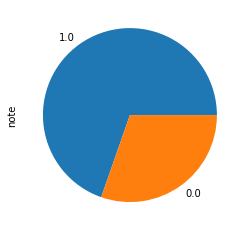

In [42]:
df['note'].value_counts().plot.pie()

créer deux dataframes

In [43]:
df_good = df[df['note'] == 1]
df_bad = df[df['note'] == 0]

# créer un aléatoire
df_good =  df_good.sample(frac=1).reset_index(drop=True)
df_bad = df_bad.sample(frac=1).reset_index(drop=True)

### <b>sans data augmentation, en équilibrant les targets</b>

équilibrer et concaténer les dataframes

In [44]:
taille_pour_equilibrer_les_notes = df_bad.shape[0]

data = df_good.iloc[:taille_pour_equilibrer_les_notes]

data = pd.concat((data, df_bad), ignore_index=True)

In [45]:
# sauvegarde du fichier csv
data.to_csv('data.csv', index=False)

<AxesSubplot:ylabel='note'>

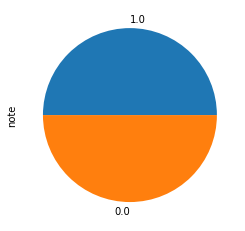

In [46]:
data['note'].value_counts().plot.pie()

## Créer un jeu de train, un jeu de test, un jeu de validation

In [47]:
variable = data['commentaire'] 
target = data['note']

X_train_test, X_val, y_train_test, y_val = train_test_split(variable, target, test_size = 0.1, stratify = target)
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size = 0.2, stratify = y_train_test)

In [48]:
print(f'{variable.shape[0]:-<10}nombre de variables totales')
print(f'{X_train.shape[0]:-<10}nombre de variables du jeu d\'entraînement')
print(f'{X_test.shape[0]:-<10}nombre de variables du jeu de test')
print(f'{X_val.shape[0]:-<10}nombre de variables du jeu de validation')

29768-----nombre de variables totales
21432-----nombre de variables du jeu d'entraînement
5359------nombre de variables du jeu de test
2977------nombre de variables du jeu de validation


### Data augmentation   

##### pour utilisation dans train.ipynb

In [49]:
# recréer un dataframe à partir de X_train et y_train pour faire de la data augmentation sur les commentaires négatifs, minoritaires
da1 = X_train.copy()
da1 = X_train.reset_index(drop=True)
da2 = y_train.copy()
da2 = y_train.reset_index(drop=True)
da1 = pd.DataFrame(da1)
da1['note'] = da2

dbad = da1[da1['note'] == 0]

In [20]:
# ref https://pypi.org/project/BackTranslation/
from BackTranslation import BackTranslation
trans = BackTranslation(url=[
      'translate.google.com',
      'translate.google.co.kr',
    ], proxies={'http': '127.0.0.1:1234', 'http://host.name': '127.0.0.1:4012'})

# trouver l'indicatif de l'allemand (langue suffisamment différente du français)
trans2 = BackTranslation()
trans.searchLanguage('German')

{'german': 'de'}

In [21]:
# test commentaire avec backTranslation
result = trans.translate(dbad.iloc[1,0], src='fr', tmp = 'de')
print(result.result_text)

Déception que les principaux acteurs ne sont toujours pas convaincants, seul Rogue est une question de l'histoire.Contrairement à Bon Point Book pour les scènes La Penine, la dame grise du bouclier d'entraînement autour du château, qui a été trouvé avec succès


In [22]:
# texte initial
dbad.iloc[1,0]

' déception les acteurs principaux sont toujours aussi peu convaincants seul rogue relève niveau histoire est niaise contrairement livre bon point pour les scènes la pensine la dame grise de formation destruction bouclier autour chateau que ai trouvé réussies '

In [23]:
# lancer la data-augmentation (environ 8h)

# liste = []
# for i in tqdm(range(dbad.shape[0])):
#     try:
#         result = trans.translate(dbad.iloc[i,0], src='fr', tmp = 'de')
#         liste.append(result)
#     except:
#         continue

In [24]:
# liste2 = np.array(liste)
# liste2 = pd.DataFrame(liste)

# liste2.to_csv('dataaug.csv', index=False)

In [100]:
dfbad = pd.read_csv('dataaug.csv')

In [101]:
liste = []
for i in range(dfbad.shape[0]):
    str = dfbad.iloc[i, 0].replace('Trabslated(src=fr, tmp=de, result_text=', '')
    str = str.replace(')', '')
    dfbad.iloc[i, 0] = str


dfbad['note'] = 0
dfbad = dfbad.rename(columns={dfbad.columns[0]:'commentaire'})

In [102]:
dfbad.to_csv('dataaug2.csv', index=False)

In [103]:
dfbad = pd.read_csv('dataaug2.csv')

In [105]:
dfbad.head()
da1.head()

,commentaire,note
0,histoire assez linéaire sans climax particuli...,1.0
1,excellent au cinéma sa sortie étais subjuguée...,1.0
2,plus dix ans après memento nous sort film mag...,1.0
3,énième coup génie infatigable nolan honnêteme...,1.0
4,navet film extrémement décevant scenario bacl...,0.0


In [107]:
df = pd.concat((dfbad, da1))

In [108]:
X_train = df['commentaire'].copy()
y_train = df['note'].copy()

## voir la répartion des mots selon les commentaires positifs ou négatifs

In [26]:
# créer deux dataframes séparés selon la note

commentaires_good = ""
commentaires_bad = ""

for comm in range(X_train.shape[0]):


    if y_train.iloc[comm] == 1:

        commentaires_good = commentaires_good + str(X_train.iloc[comm])
    
    else:
        commentaires_bad = commentaires_bad + str(X_train.iloc[comm])

In [27]:
nombre_mots = 100

WC_good = WordCloud(background_color = 'white', stopwords = stopwords.words('french'), max_words = nombre_mots).generate(commentaires_good)
WC_bad = WordCloud(background_color = 'white', stopwords = stopwords.words('french'), max_words = nombre_mots).generate(commentaires_bad)

In [28]:
# récupérer les dictionnaires de mots
dico_good = WC_good.words_
dico_bad = WC_bad.words_

In [29]:
# les mettre en listes
li_good = np.array(list(dico_good.keys()))
li_bad = np.array(list(dico_bad.keys()))

# comparer les deux listes
blacklist_mots = np.intersect1d(li_good, li_bad)
blacklist_mots = list(blacklist_mots)
len(blacklist_mots)

72

> sur 100 mots importants, entre 65 et 75 mots sont communs (selon l'alétaoire de la séparation du jeu de données) entre les bons commentaires et les mauvais commentaires

## Visualisation d'un commentaire avec deux traitements différents

In [30]:
print('==== phrase du df ====')
print(X_train.iloc[9] + '\n')
print('==== lemmatization ====')
print(lemm_stem(X_train, type = 'lemm').iloc[9] + '\n')
print('==== stemming ====')
print(lemm_stem(X_train).iloc[9])

==== phrase du df ====
 m avait beaucoup parlé ce film comme étant film génial extraordinaire mythique est peut être cause cela m attendant un chef oeuvre cinéma que ai été déçu par film histoire est touchante les personnages sont accrochants très bien joué cepeda je trouve il a énormément longueurs qui casse ambiance film sa dynamique plus ne suis pas fan spoiler pouvoir guérison jhon coffey interprété par michael clarke duncan cela rend histoire non réaliste peu crédible est vraiment dommage 

==== lemmatization ====
 beaucoup  parle  film  comme  etant  film  genial  extraordinaire  mythique  peut  etre  cause  cela  attendant  chef  oeuvre  cinema  ete  decu  film  histoire  touchante  personnages  accrochants  tres  bien  joue  cepeda  trouve  a  enormement  longueur  casse  ambiance  film  dynamique  plus  fan  spoiler  pouvoir  guerison  jhon  coffey  interprete  michael  clarke  duncan  cela  rend  histoire  non  realiste  peu  credible  vraiment  dommage 

==== stemming ====
 

## Visualisation et récupération des nuages de mots

In [119]:
# créer deux datasets : avec stemming, avec lemmization
X_lemmization = lemm_stem(X_train, type='lemm')
X_stemming = lemm_stem(X_train)

In [ ]:
# appliquer le même traitement sur les données de test et de validation
X_train_lemm = X_lemmization.copy()
X_train_stem = X_stemming.copy()


X_test_lemm = lemm_stem(X_test, type='lemm')
X_test_stem = lemm_stem(X_test)

X_val_lemm = lemm_stem(X_val, type='lemm')
X_val_stem = lemm_stem(X_val)

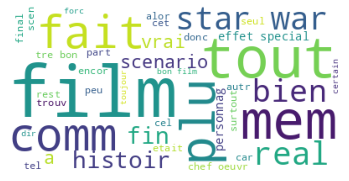

In [ ]:
# visualisation du sac de mots selon le stemming

sta = ""

for i in range(X_stemming.shape[0]):

    sta = sta + " " + X_stemming.iloc[i] + " "


afficher_nuage_mots(sta, nombre_de_mots=40)

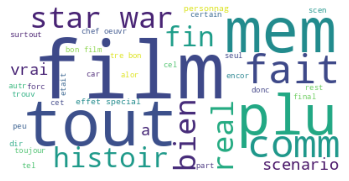

In [ ]:
# visualisation du sac de mots selon la lemmatization

stb = ""

for i in range(X_lemmization.shape[0]):

    stb = stb + " " + X_lemmization.iloc[i] + " "


afficher_nuage_mots(stb, nombre_de_mots=40)

In [120]:
# récupérer les mots importants par sacs de mots

nombre_mots2 = 500

sac_de_mots_lemm = WordCloud(background_color = 'white', stopwords = stopwords.words('french'), max_words = nombre_mots2).generate(stb).words_
sac_de_mots_stem = WordCloud(background_color = 'white', stopwords = stopwords.words('french'), max_words = nombre_mots2).generate(sta).words_


# exporter les mots dans un fichier json
with open('wordsBag.json', 'w', encoding ='utf8') as json_file:
    json.dump(sac_de_mots_stem, json_file)


# transformer les mots (clé du dictionnaire) en listes
sac_de_mots_lemm = list(sac_de_mots_lemm.keys())
sac_de_mots_stem =  list(sac_de_mots_stem.keys())

In [ ]:
# ne garder que les mots sélectionnés dans les dataframes

X_train_stem = intersection(X_train_stem, sac_de_mots_stem)
X_test_stem = intersection(X_test_stem, sac_de_mots_stem)
X_val_stem = intersection(X_val_stem, sac_de_mots_stem)

# Apprentissage

### transformer les mots en matrices

In [ ]:
cvec = CountVectorizer()

In [ ]:
# apprentissage sur les données d'entraînement

cvec.fit(sac_de_mots_stem)

CountVectorizer()

In [ ]:
# appliquer la transformation sur les différents jeux de données

X_train = pd.DataFrame(cvec.transform(X_train_stem).todense().tolist())
X_test = pd.DataFrame(cvec.transform(X_test_stem).todense().tolist())
X_val = pd.DataFrame(cvec.transform(X_val_stem).todense().tolist())

### apprentissage par régression logisitique

In [72]:
param = {
    'max_iter' : [1000, 10000], 
    'C' : [0.1, 0.4, 0.7],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'warm_start' : [True, False]
}


model = GridSearchCV(LogisticRegression(), param_grid=param, cv=5)


model.fit(X_train, y_train) 
score_train = model.best_score_
score_test = model.score(X_test, y_test)
score_val = model.score(X_val, y_val)

In [73]:
print(f'{score_train:-<30} score sur les données d\'entraînement')
print(f'{score_test:-<30} score sur les données de test')
print(f'{score_test:-<30} score sur les données de validation')

0.8275942515864129------------ score sur les données d'entraînement
0.8259003545437582------------ score sur les données de test
0.8259003545437582------------ score sur les données de validation


In [74]:
# meilleurs paramètres du modèle
model.best_params_

{'max_iter': 1000}

<AxesSubplot:>

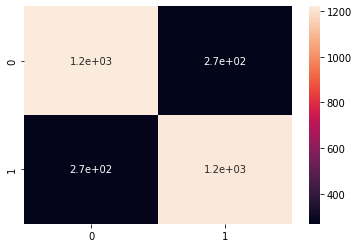

In [75]:
mat = confusion_matrix(y_val, model.predict(X_val) )

sb.heatmap(mat, annot=True)


In [78]:
#export des modèles 
joblib.dump(model, 'model.joblib')
joblib.dump(cvec, 'cvec.joblib')

['cvec.joblib']